# Demo of `SpatialReference` class

### why
Most models require spatially-distributed data, and their results are more meaningful when plotted on a map.

### purpose of class:
* lightweight (doesn't take minutes to load) representation of model grid in geographic coordinates for relating the model to external data
* transformations between model coordinates and geographic coorindates*
* convenience methods for mapping geographic data to model grid and model results to geographic coordinates

***Note:** the term "geographic" is used loosely here to denote any coordinate system that can locate something on earth. Mostly we are talking about projected coordinate systems that have a length unit of meters, such as UTM.

In [28]:
import os
import numpy as np
from flopy.grid import StructuredModelGrid
from flopy.grid import SpatialReference
from flopy.utils import SpatialReference as OGsr
import matplotlib.pyplot as plt
% matplotlib inline

In [29]:
tmpdir = 'tmp'
if not os.path.isdir(tmpdir):
    os.makedirs(tmpdir)

### Make a spatial reference object
* the sr provides transformations from an attached grid class (`.modelgrid` attribute)
* modelgrid can be supplied as an argument or created from supplied delr and delc arrays, as [in the existing version of `SpatialReference`](https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3_SpatialReference_demo.ipynb)

In [30]:
sr = SpatialReference(delc=np.ones(10), delr=np.ones(10),
                      xll=10, yll=10, rotation=20,
                      epsg=26715, # coordinate reference for UTM meters, zone 15 N
                      lenuni=1, # model grid in feet
                          )
sr.modelgrid

### the key method is `.transform()`
* performs all transformations between model and geographic coordinates, by applying rotation, scaling (e.g. feet vs. meters) and offset.
* takes x and y locations as arguments
* default is from model coordinates to real or geographic coordinates
* an `inverse` argument allows for transformation of geographic coordinates to model coordinates

In [31]:
sr.transform(10, 10)

(11.82170571129881, 13.906660505012088)

In [32]:
sr.transform(11.82170571129881, 13.906660505012088, inverse=True)

(9.999999999999995, 10.000000000000005)

## key attributes

### cell center and edge (or corner) coordinates
* the `.*centers` and `.*edges` attributes return 2d (nrow, ncol) numpy arrays for easy indexing
* the underlying `ModelGrid`-based class as the same attributes, providing untransformed locations
* all of the key attributes work with scalars, lists, or numpy arrays

In [33]:
sr.xcenters[1, 7] # x-coordinate at row 1, column 7

11.262031543788444

In [34]:
sr.xcenters[[1, 3], [7, 7]]

array([11.26203154, 11.47052702])

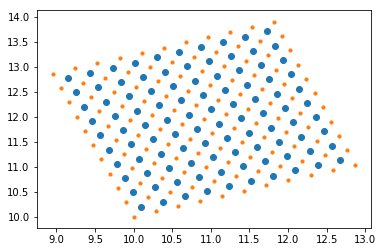

In [35]:
plt.scatter(sr.xcenters.ravel(), sr.ycenters.ravel())
plt.scatter(sr.xedges.ravel(), sr.yedges.ravel(), s=10)

### center and edge attributes for underlying model grid
in the model coordinate system with an origin at the upper left corner.

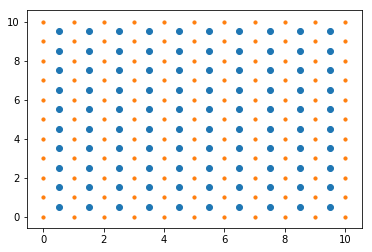

In [36]:
plt.scatter(sr.modelgrid.xcenters.ravel(), sr.modelgrid.ycenters.ravel())
plt.scatter(sr.modelgrid.xedges.ravel(), sr.modelgrid.yedges.ravel(), s=10)

### Grid lines

In [37]:
def plot_lines(lines):
    fig, ax = plt.subplots()
    for ln in lines:
        plt.plot([ln[0][0], ln[1][0]], [ln[0][1], ln[1][1]])

(11, -1)

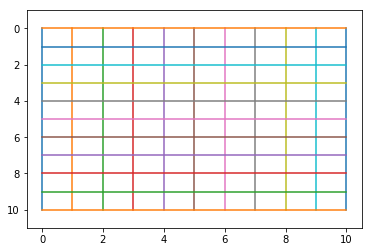

In [38]:
plot_lines(sr.modelgrid.gridlines)
plt.ylim(11, -1)

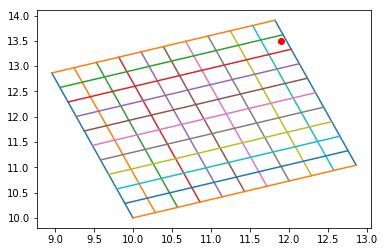

In [39]:
plot_lines(sr.gridlines)
plt.scatter(11.9, 13.5, c='r')

### cell vertices

In [40]:
sr.modelgrid.vertices[0]

[[0.0, 10.0], [0.0, 9.0], [1.0, 9.0], [1.0, 10.0], [0.0, 10.0]]

In [41]:
sr.vertices[0]

[[8.957522603143362, 12.864183108155448],
 [9.061770342829025, 12.577764797339904],
 [9.34818865364457, 12.68201253702557],
 [9.243940913958907, 12.968430847841113],
 [8.957522603143362, 12.864183108155448]]

(0, 24)

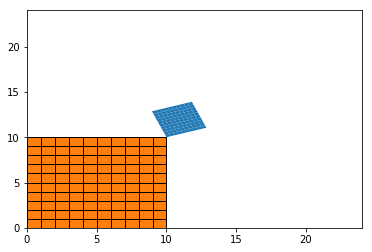

In [42]:
from flopy.utils.geometry import Polygon
from matplotlib.collections import PatchCollection

sr_patches = [Polygon(v).patch for v in sr.vertices]
mg_patches = [Polygon(v).patch for v in sr.modelgrid.vertices]
fig, ax = plt.subplots()
ax.add_collection(PatchCollection(sr_patches))
ax.add_collection(PatchCollection(mg_patches, color='C1', edgecolor='k'))
ax.set_xlim(0, 24)
ax.set_ylim(0, 24)

## Applications

### get the row column index of a location in geographic coordinates
(e.g. for setting up observation data)

In [43]:
sr.get_rc(11.9, 13.5)

(1, 9)

In [44]:
datadir = '../data/br/dem.tif'

### Sample data from a raster

In [45]:
from flopy.utils.preprocessing import get_values_at_points
from matplotlib.colors import LightSource
ls = LightSource(azdeg=315, altdeg=45)


##### make another sr

In [46]:
nrow, ncol = 300, 500
dxy = 100 # feet (model coordinates)
xll = 680500
yll = 5137500
rotation = 0.

sr = SpatialReference(delc=np.ones(nrow)*dxy, delr=np.ones(ncol)*dxy,
                      xll=xll, yll=yll, rotation=rotation,
                      epsg=26715, # coordinate reference for UTM meters, zone 15 N
                      lenuni=1, # model grid in feet
                          )
sr

xul:680500; yul:5146644; rotation:0; proj4_str:+proj=utm +zone=15 +ellps=clrk66 +datum=NAD27 +units=m +no_defs ; units:meters; lenuni:1; length_multiplier:0.3048

### the `sample()` method returns the values of raster pixels closest to cell centers (newly implemented)
* could be easily extended to do zonal statistics instead
* requires the python `gdal` bindings, which come with `conda install rasterio`

In [47]:
results = sr.sample('../data/br/dem.tif')

reading data from ../data/br/dem.tif...
sampling...
finished in 0.01s


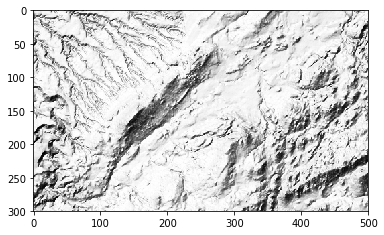

In [48]:
plt.imshow(ls.hillshade(results), cmap='Greys_r')

### the `intersect()` method intersects vector features with the model grid (newly implemented)
* takes a shapefile, list of `flopy.utils.geometry` features, or dataframe with `geometry` column (as you would get with `flopy.utils.shapefile_utils.shp2recarray`. (`shapely` objects could easily be supported as well)
* `id_column` argument allows the numerical value for each feature to be specified; default is the feature index position

##### limitations
* right now the shapefile must be in the same CRS as the sr, but reprojection could be easily supported with the user supplying a proj4 string or epsg code
* with the `fiona` package as an option dependency, reprojection wouldn't require any additional user input, as long as there was a .prj file.
* currently only rasterization is supported, where only a single feature is intersected with each cell, if the cell centroid is within that feature (I'm guessing the ordering is based on feature index position)
* a more sophisticated spatial join option could be implemented, but would require the `shapely` and `rtree` packages, or maybe just `geopandas`, which [looks to be gaining some steam](http://matthewrocklin.com/blog/work/2017/09/21/accelerating-geopandas-1), and can be easily installed from conda forge. Spatial join is generally required for more sophisticated tasks like building the stream network.

In [49]:
results = sr.intersect('../data/br/catchments.shp')

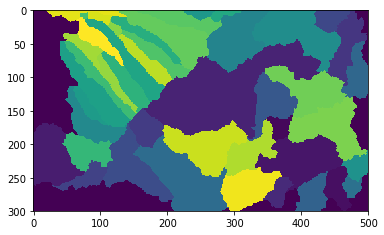

In [50]:
plt.imshow(results)

### `interpolate()` for resampling a grid (existing method)

##### for example, transfering information to an inset model

In [51]:
# make an inset model
nrow, ncol = 500, 500
dxy = 10 # feet (model coordinates)
xll = 682000
yll = 5139000
rotation = 30.

sr2 = SpatialReference(delc=np.ones(nrow)*dxy, delr=np.ones(ncol)*dxy,
                      xll=xll, yll=yll, rotation=rotation,
                      epsg=26715, # coordinate reference for UTM meters, zone 15 N
                      lenuni=1, # model grid in feet
                          )